### CNN First Version
- Train Accuracy: 0.7250, Validation Accuracy: 0.3840
- Applied data augmentation to improve generalization
- Added 1 Convo+Pooling+dropout layer
- Used Keras Tuner for random search

In [1]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
import keras_tuner as kt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

2025-07-31 22:01:16.476909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754013676.524745 2300431 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754013676.539654 2300431 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754013676.622826 2300431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754013676.622886 2300431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754013676.622889 2300431 computation_placer.cc:177] computation placer alr

In [ ]:
with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

# load data for 10 subclasses
X_train = data['X_train_sub_bbox'] 
y_train = data['y_train_sub_bbox']
X_val = data['X_val_sub_bbox']
y_val = data['y_val_sub_bbox']

breed = data['classes_sub_bbox']
num_breeds = len(breed)
breed_ids = [i for i in range(len(breed))]
breed_id_map = {breed[i]:i for i in range(len(breed))}
id_breed_map = {id: label for label, id in breed_id_map.items()}
y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])

print(f"{num_breeds} breeds in total")
print(breed)

10 breeds in total
['flat' 'german_short' 'american_staffordshire_terrier' 'ibizan_hound'
 'cairn' 'kerry_blue_terrier' 'maltese_dog' 'bedlington_terrier'
 'english_setter' 'sussex_spaniel']


In [8]:
# Check size
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"First 5 breeds in train: {y_train[:5]}")

X_train shape: (1000, 64, 64, 3)
X_val shape: (388, 64, 64, 3)
First 5 breeds in train: [3 8 1 7 4]


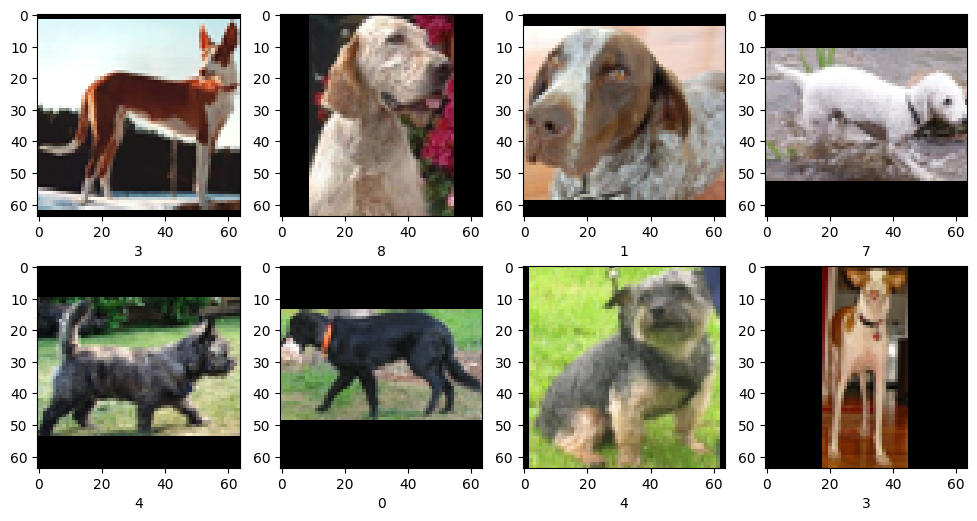

In [6]:
cols = 4
plt.figure(figsize=(cols * 3, 6)) 
for i in range(8):
    plt.subplot(2, cols, i + 1)
    plt.grid(False)
    img = array_to_img(X_train[i])
    plt.imshow(img)
    plt.xlabel(y_train[i])
plt.show()

Transformation and augmentation
- flip left and right - Dog images are usually symmetric, so flipping is safe
- random room in - Adds robustness to zoom
- Color and Lighting - ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)

In [13]:
def preprocess_data_part(X_train, labels, delta=0.2):
    """ apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    """
    tf.random.set_seed(42)
    np.random.seed(42)
    
    # image augmentation - 1. random flip
    X_train_flip = tf.image.flip_left_right(X_train) 
    
    # image augmentation - 2. random rotation
    rotation_layer = tf.keras.layers.RandomRotation(factor=10/360.0)
    X_train_rotate = rotation_layer(X_train, training=True)

    # image augmentation - 3. scale <------------- this seems reasonable as some of the images has a big white space
    # resize_layer = tf.keras.layers.Resizing()
    # X_train_resize = tf.image.resize(X_train, target_size)

    # image augmentation - 4. adjusting color
    X_train_color = tf.image.random_brightness(X_train, max_delta=delta)
    X_train_color = tf.image.random_contrast(X_train_color, lower=1 - delta, upper=1 + delta)
    X_train_color = tf.image.random_saturation(X_train_color, lower=1 - delta, upper=1 + delta)

    # # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate((X_train, X_train_flip, X_train_rotate, X_train_color), axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm1 = labels
    y_train_augm2 = labels
    y_train_augm3 = labels
    y_train_augm4 = labels
    # y_train = tf.concat([labels, y_train_augm1, y_train_augm2, y_train_augm3], axis=0)
    y_train = tf.concat([labels, y_train_augm1, y_train_augm3, y_train_augm4], axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # if isinstance(y_train[0], bytes):
    #     y_train = np.array([s.decode('utf-8') for s in y_train])

    return X_train, y_train

X_train_aug, y_train_aug = preprocess_data_part(X_train, y_train)
print(X_train_aug.shape)
print(y_train_aug.shape)

(4000, 64, 64, 3)
(4000,)


#### Use Keras tuner on CNN

In [14]:
# Build a CNN architecture
def model_builder_for_n_classes(num_classes = num_breeds):
    def model_builder(hp):
        # initialize model
        tf.keras.backend.clear_session()
        random.seed(42)
        tf.random.set_seed(42)
        np.random.seed(42)
        
        model = tf.keras.Sequential()

        # add convolutional layer
        hp_filters = hp.Int('filters', min_value=8, max_value=64, step=8)
        hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=4, step=1)
        kernel_tuple = (hp_kernel_size, hp_kernel_size)
        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

        model.add(tf.keras.layers.Conv2D(
            filters=hp_filters,
            kernel_size=kernel_tuple,
            activation=hp_activation,
            padding='same',
            input_shape=(64, 64, 3)
        ))
        
        hp_pool = hp.Int('pool_size', min_value=2, max_value=4, step=1)
        model.add(tf.keras.layers.MaxPooling2D(pool_size=hp_pool))

        hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dropout(rate=hp_dropout))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

        # build and compile model
        model.build(input_shape=(None, 64, 64, 3))
        hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        return model
    return model_builder

In [15]:
tuner = kt.RandomSearch(
    model_builder_for_n_classes(10),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning',
    overwrite=True
)

tuner.search_space_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)

tuner.search(
    X_train_aug, y_train_aug,  # make sure this is integer encoded
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Trial 20 Complete [00h 00m 09s]
val_accuracy: 0.2680412232875824

Best val_accuracy So Far: 0.44072166085243225
Total elapsed time: 00h 03m 29s


In [16]:
# get the hyperparamers from the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

filters: 32
kernel_size: 4
activation: relu
pool_size: 4
dropout: 0.4
learning_rate: 0.001


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1)

print("Best model summary:")
print(best_model.summary())

train_acc = history.history['accuracy'][-1]
val_acc =  history.history['val_accuracy'][-1]
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2122 - loss: 2.1725 - val_accuracy: 0.3402 - val_loss: 1.7815
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4631 - loss: 1.5720 - val_accuracy: 0.3711 - val_loss: 1.7403
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5613 - loss: 1.2840 - val_accuracy: 0.4046 - val_loss: 1.7031
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6309 - loss: 1.0829 - val_accuracy: 0.4253 - val_loss: 1.7024
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7008 - loss: 0.9133 - val_accuracy: 0.4304 - val_loss: 1.7493
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7557 - loss: 0.7910 - val_accuracy: 0.4381 - val_loss: 1.8406
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7864 - loss: 0.6961 - val_accuracy: 0.4149 - val_loss: 1.8519
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8205 - loss: 0.5890 - val_accuracy: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        81,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,496 (978.50 KB)

 Trainable params: 83,498 (326.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,998 (652.34 KB)

None
Train Accuracy: 0.9358, Validation Accuracy: 0.4021


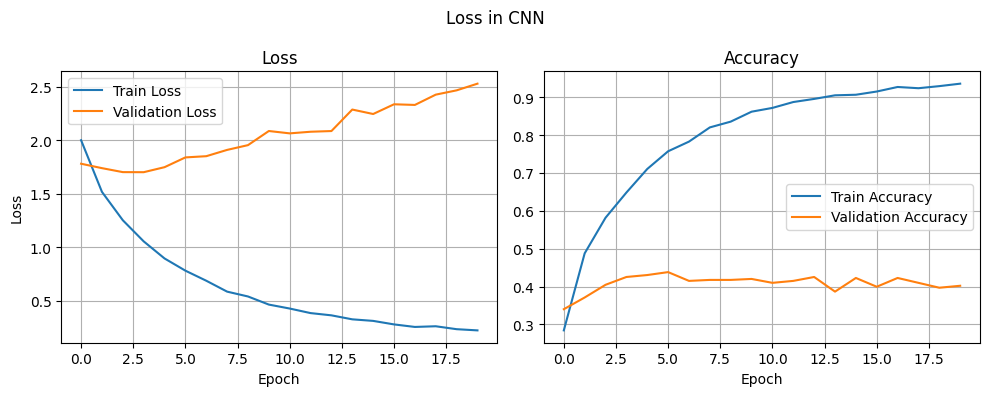

In [24]:
def plot_acc_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Plot Train Loss
    axes[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Loss
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
    axes[1].set_title("Accuracy")  
    axes[1].set_xlabel("Epoch")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Loss in CNN", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_acc_loss(history)